# Demo: inference with UPerNet + Swin backbone for semantic segmentation

[UPerNet](https://arxiv.org/abs/1807.10221) 是一个经典的计算机视觉框架，于2018年推出，用于图像分割。作为一个“框架”（这意味着它是由多个构建模块组成的复杂系统），它可以与任何视觉主干网络一起使用，例如：
- [ConvNeXt](https://huggingface.co/docs/transformers/model_doc/convnext),
- [Swin Transformer](https://huggingface.co/docs/transformers/model_doc/swin),
- [Vision Transformer](https://huggingface.co/docs/transformers/model_doc/vit)

etc.

![架构图](./img/UPerNet.jpeg)

一些论文在引入新的视觉主干时，会将其与这个框架进行基准测试，以观察该主干是否真正改善了下游任务（如语义分割）的结果。语义分割的性能通过[平均交并比, mean Intersection-over-Union (mIoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou)来报告。

## Load image 加载图片

让我们从[ADE20k数据集](https://huggingface.co/datasets/scene_parse_150)加载图像。ADE20k是图像分割领域的重要基准数据集。为了方便使用,我们已经将一张示例图片下载到本地的img文件夹中。

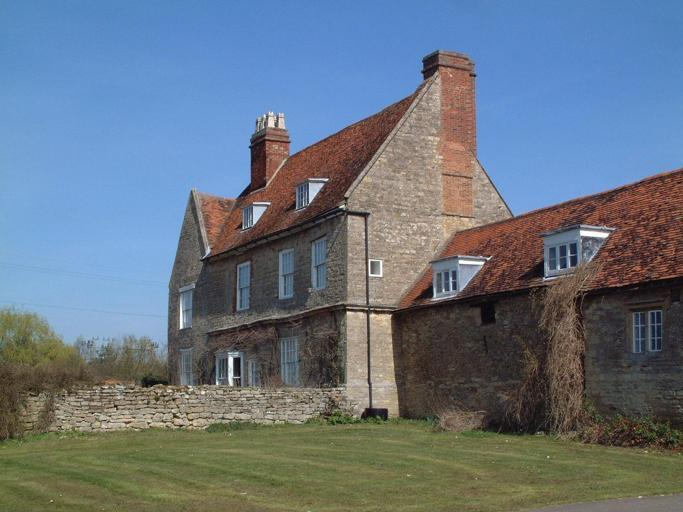

In [2]:
from PIL import Image

url = "./img/ADE_val_00000001.jpg"
image = Image.open(url)
image 

## Load model 加载模型

接下来，我们将从[hub](https://huggingface.co/openmmlab/upernet-swin-base)加载模型。在本例中，我们加载具有 Swin-base 主干的 UperNet 模型。

In [3]:
from mindnlp.transformers import UperNetForSemanticSegmentation

model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-large")

/root/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.914 seconds.
Prefix dict has been built successfully.


## Forward pass 前向传播


接下来，我们准备图像以供模型使用，并将像素值输入到模型中。

In [4]:
from mindnlp.transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-large")
pixel_values = processor(image, return_tensors="ms").pixel_values
print(pixel_values.shape)

(1, 3, 512, 512)


In [5]:
outputs = model(pixel_values)

模型输出每个像素的 logits（未归一化的分数），其形状为 (batch_size, 标签数量, 高度, 宽度)。因此，模型为每个像素输出每个类别的置信分数。

我们将简单地取每个像素的最高分作为该像素的预测结果。

In [6]:
print(outputs.logits.shape)

(1, 150, 512, 512)


## Visualize predictions 可视化预测

为了可视化，我们首先定义一个颜色调色板（color palette），将每个ADE20k的150个类别映射到一种颜色（红色、绿色和蓝色值）。

In [7]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

为了进行可视化，我们将图像与预测的标记叠加。

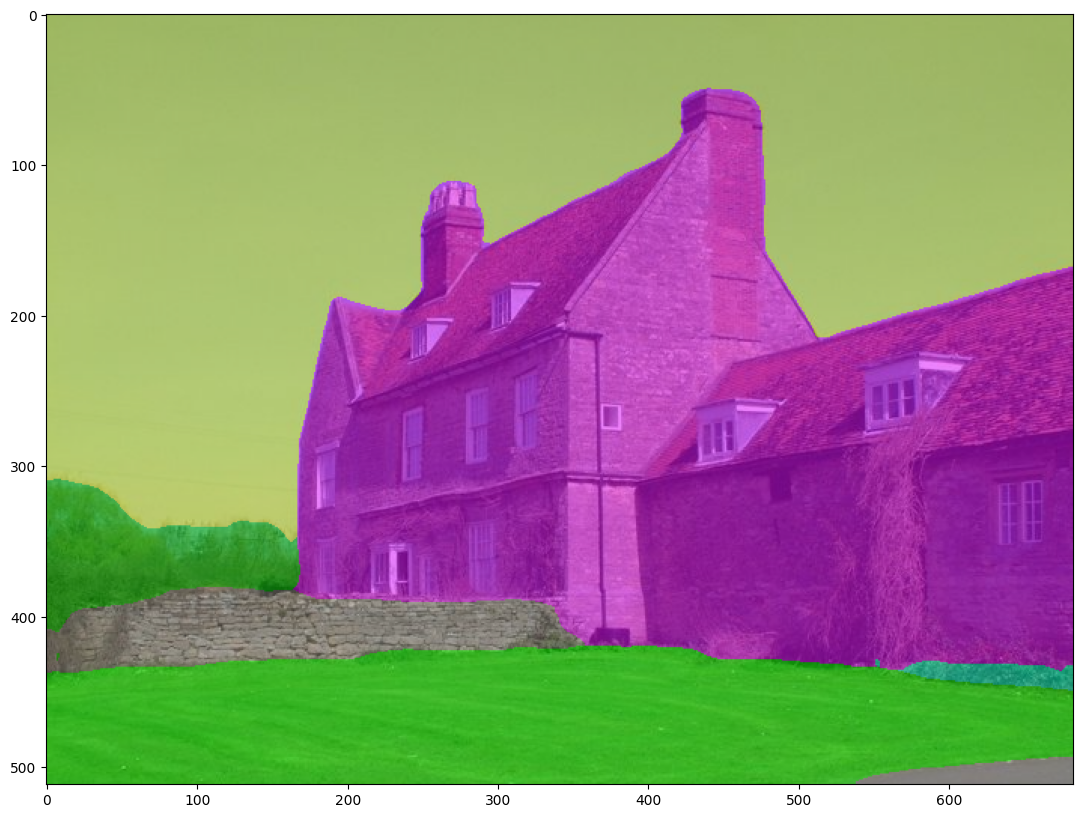

In [8]:
import matplotlib.pyplot as plt 
import numpy as np

seg = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0].asnumpy()
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())

for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()